<a href="https://colab.research.google.com/github/ptrkrlsrd/skyscanner/blob/main/sunset_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from fastai.vision.all import *
from fastai import *
import os

# Metavariables

In [72]:
ROOT_FOLDER = './'
DATA_FOLDER = './data/'
IMAGES_PATH = os.path.join(DATA_FOLDER, "images")

MODEL_PATH = 'model.pk1'
SHOULD_LOAD_MODEL = False
EPOCHS = 5

# Copy images from Google Drive

In [59]:
import shutil
from zipfile import ZipFile


zipped_images = 'images.zip'
zipped_IMAGES_PATH = './drive/MyDrive/'

origin_path = os.path.join(zipped_IMAGES_PATH, zipped_images)
target_path = os.path.join(DATA_FOLDER, zipped_images)

if not os.path.exists(DATA_FOLDER):
  os.mkdir(DATA_FOLDER)

shutil.copy(zipped_IMAGES_PATH + zipped_images, target_path)
print("Files are copied successfully")

with ZipFile(target_path, 'r') as zipObj:
   zipObj.extractall(path=DATA_FOLDER)

Files are copied successfully


# If needed, clear the image data

In [ ]:
from pathlib import Path
from shutil import rmtree

def remove_images():
  for path in Path("./data/").glob("**/*.jpg"):
      if path.is_file():
          path.unlink()
          #print(path)
      elif path.is_dir():
          rmtree(path)
          #print("dir")

# Load images

In [13]:

get_files = lambda n: get_image_files(os.path.join(IMAGES_PATH, n))

interesting_images = get_image_files(os.path.join(IMAGES_PATH, "interesting"))
boring_images = get_image_files(os.path.join(IMAGES_PATH, "boring"))
all_images = interesting_images + boring_images

boring_dataloader = ImageDataLoaders.from_name_func(ROOT_FOLDER, boring_images, label_func=lambda f: False)
interesting_dataloader = ImageDataLoaders.from_name_func(ROOT_FOLDER, interesting_images, label_func=lambda f: True)

# Transform images and merge dataloaders

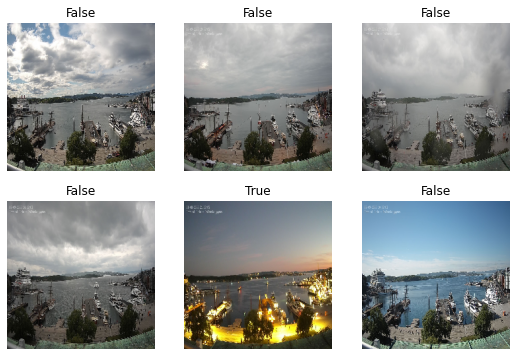

In [62]:
import albumentations as A

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
 
 
def get_valid_aug(): return A.Compose([
    A.Resize(224,224),
], p=1.)

def get_train_aug(): return A.Compose([
    A.Resize(224,224),
])

item_tfms = [AlbumentationsTransform(get_train_aug(),get_valid_aug())]

labels = ["interesting" in i.parts for i in all_images]
df = ImageDataLoaders.from_lists(ROOT_FOLDER, all_images, labels, item_tfms=item_tfms)

df.show_batch(max_n=6)

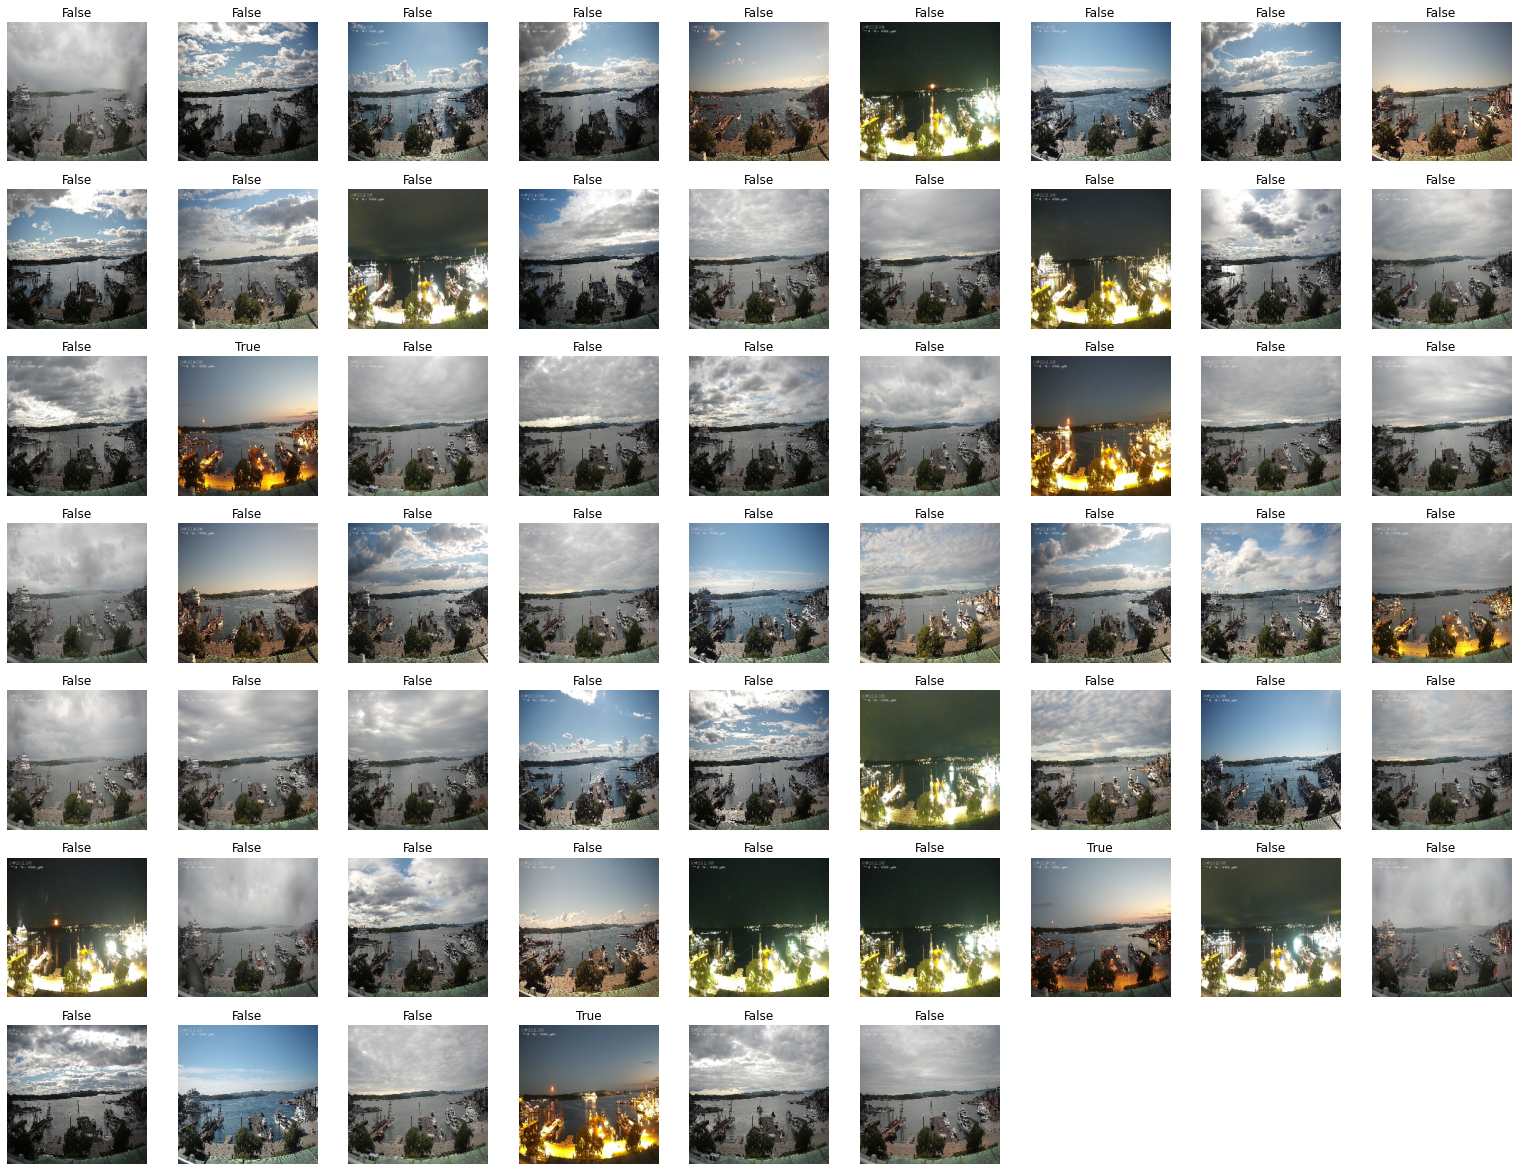

In [63]:
df.show_batch(max_n=60)

# Train the model

In [71]:

learn = load_learner(MODEL_PATH) if SHOULD_LOAD_MODEL else vision_learner(df, resnet34, metrics=error_rate)
learn.fine_tune(EPOCHS)

if SHOULD_LOAD_MODEL is False:
  learn.export(MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Test predictions

In [47]:
learn.predict(interesting_images[0])

('True', TensorBase(1), TensorBase([4.3735e-12, 1.0000e+00]))

In [48]:
learn.predict(boring_images[2])


('False', TensorBase(0), TensorBase([0.9776, 0.0224]))

In [ ]:
test_files = get_image_files("./test_data")
for i in test_files:
  print(i, learn.predict(i))

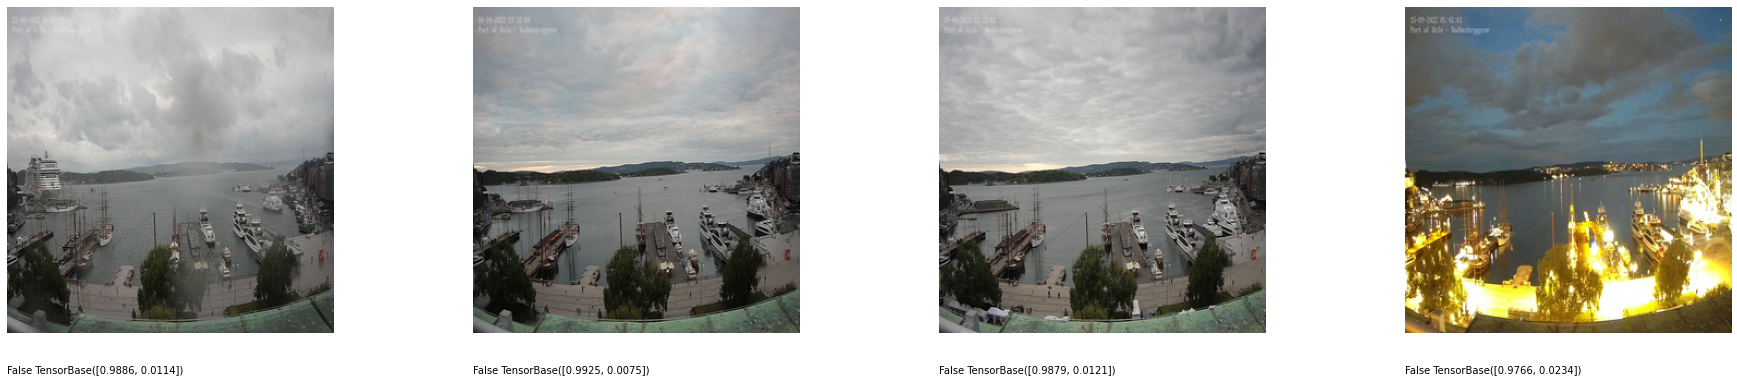

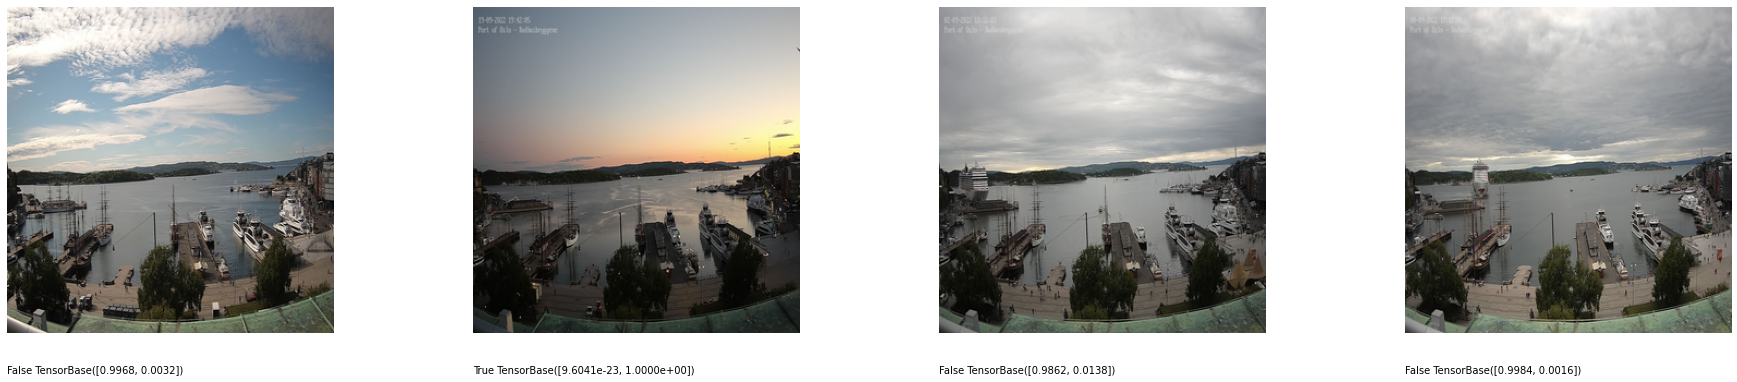

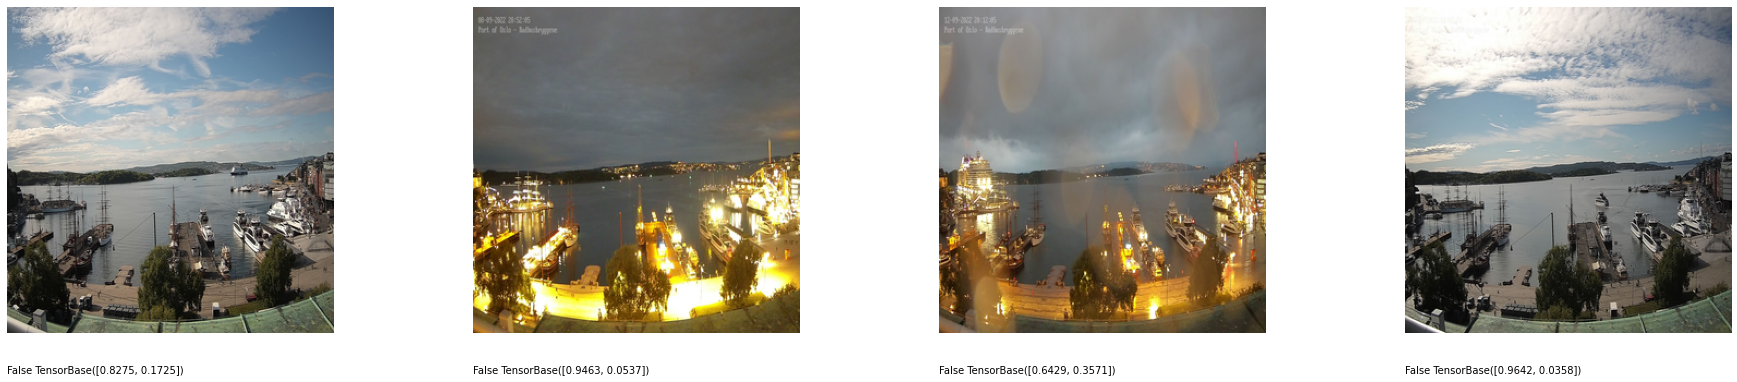

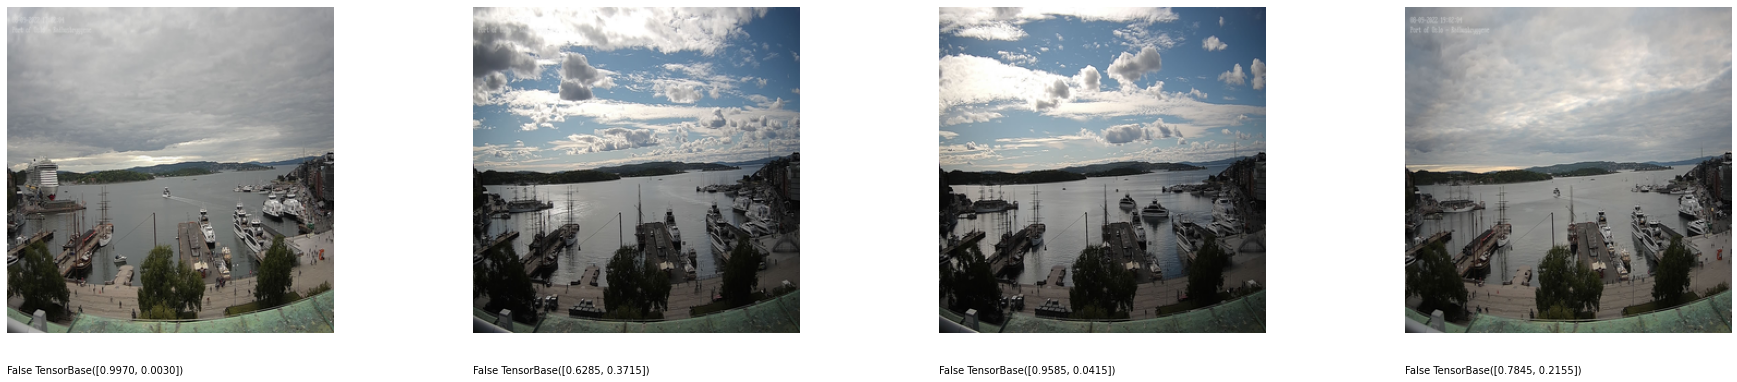

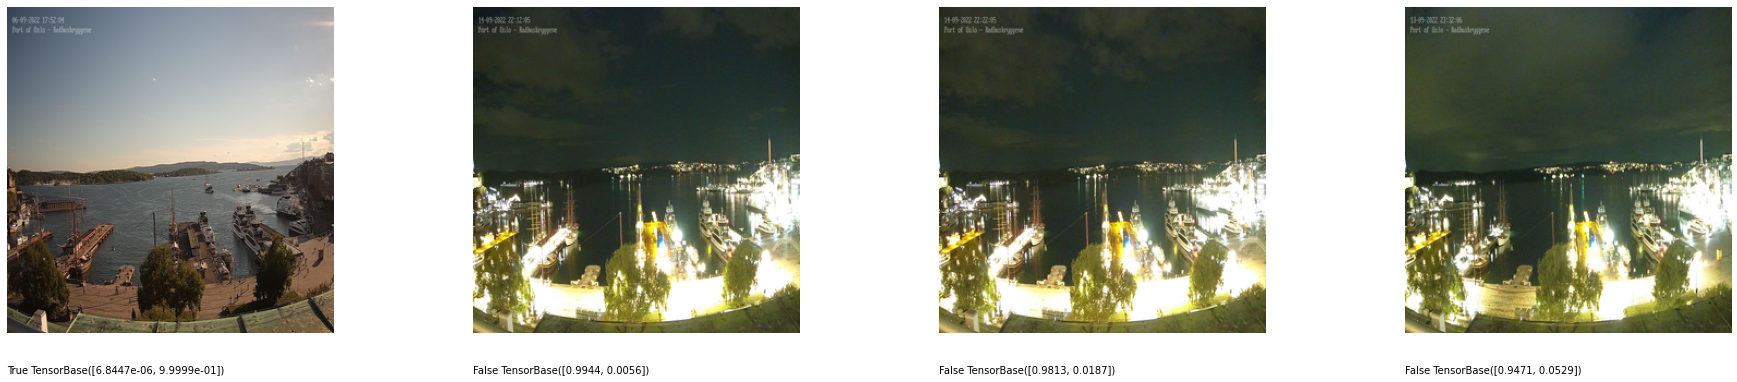

In [68]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np



def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(img_shape, Image.ANTIALIAS)
    )
    
    return img_array

def image_grid(fn_images : list, 
               text_fn : callable, 
               top : int = 8, 
               per_row : int = 4,
               img_width : int = 300, img_height : int = 300):
    """
    fn_images is a list of image paths.
    text is a list of annotations.
    top is how many images you want to display
    per_row is the number of images to show per row.
    """
    for i in range(len(fn_images[:top])):
        if i % per_row == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(32, 6))
        j = i % per_row
        image = Image.open(fn_images[i])
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')
        if text_fn:
            ax[j].annotate(text_fn(image), (0,0), (0, -32), 
                           xycoords='axes fraction', 
                           textcoords='offset points', 
                           va='top')
            
test_files = get_image_files("./test_data")

def text_fn(i):
    cat,tensor,prob = learn.predict(i)
    return "{} {}".format(cat,prob)



shuffled = np.random.permutation(all_images)

image_grid(shuffled, text_fn,top=20,img_width=300,img_height=300)
